# Using Current Data To Make Recommendations
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [17]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_new_LC_data_classification_current,clean_LC_data_classification_eval,
                                   preprocessing_current, preprocessing_future_test, columns_list, 
                                   nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification, 
                                   view_columns_by_number_of_rows_that_have_nan,
                                   current_pipeline)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import New Data from 7.8.19

In [46]:
browseNotes = pd.read_csv('~/peervest/lc_data/browseNotes_7.8.19.csv')
browseNotes.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,154522518,190327199,15000.0,14800.0,36,10.33,5.14,1.03,486.34,B,...,,,,,,,,,,
1,154600521,190534584,17000.0,16725.0,36,11.71,5.14,1.03,562.30,B,...,,,,,,,,,,
2,154124100,189640879,30000.0,23025.0,36,17.97,12.63,1.49,1084.13,D,...,,,,,,,,,,
3,154334950,189967957,11150.0,8675.0,36,20.00,12.63,1.49,414.38,D,...,05-27-2013 17:00:00,0,0,5,30.1,0,12,1,1,12
4,154607088,190596210,19125.0,18325.0,60,15.24,7.28,0.86,457.40,C,...,,,,,,,,,,


In [58]:
dfs_list = [browseNotes]

In [59]:
browseNotes.shape

(98, 122)

### Load DF from Pipeline

In [115]:
(X_current_regr, y_current, table_all_current) = current_pipeline(dfs_list, 'nn_v8.joblib', 'rf_regr_v5.joblib')

/home/jupyter/peervest/functions_and_objects.py:413: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days


[]


In [129]:
len(y_current[(y_current['prob_default'] < 1) & (y_current['return_preds'] > -.1)])

80

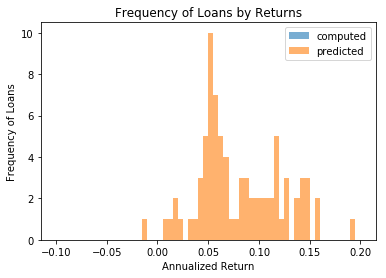

In [120]:
plt.hist(table_all_current['annu_return'],bins=60,range=(-0.1,0.2),label='computed',alpha=0.6)
plt.hist(table_all_current['return_preds'],bins=60,range=(-0.1,0.2),label='predicted',alpha=0.6)
plt.xlabel('Annualized Return')
plt.ylabel('Frequency of Loans')
plt.legend()
plt.title('Frequency of Loans by Returns')
plt.show()

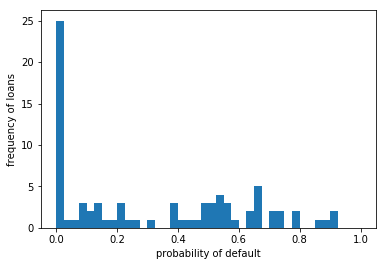

In [114]:
plt.hist(table_all_current['prob_default'],bins=40, range=(0,1))
plt.xlabel('probability of default')
plt.ylabel('frequency of loans')
plt.show()

# Recommendation Table

In [ ]:
def expected_portfolio_return_evenly_weighted(table_all_current, avail_funds):
    evenly_weighted_expected_returns = []
    for row in table_all_current:
        evenly_weighted_expected_returns.append(
            table_all_current['return_preds'][row] * (avail_funds/len(table_all_current)))
    expected_portfolio_return = sum(evenly_weighted_expected_returns)/avail_funds
    return expected_portfolio_return

def rank_table_by_shrop_ratio_RAR(table_all_current, avail_funds):
    for row in table_all_current:
        table_all_current['shrop_ratio'][row] = (
            (expected_portfolio_return_evenly_weighted(table_all_current, avail_funds) - 1.88) / 
                                                        (table_all_current['prob_default'][row]))
    table_all_current_ranked = table_all_current.sort_values(by='shrop_ratio',axis=1, ascending=False)
    return table_all_current_ranked

def recommended_loans(table_all_current, max_prob_default, min_desired_return):
    rec_table = table_all_current[(table_all_current['prob_default'] <= max_prob_default) & 
                             (table_all_current['return_preds'] >= min_desired_return)]
    return rec_table

def portfolio_prob_default_evenly_weighted(table_all_current, avail_funds):
    evenly_weighted_prob_default = []
    for row in table_all_current:
        evenly_weighted_prob_default.append(
            (table_all_current['prob_default'][row]) * (avail_funds/len(table_all_current)))
    portfolio_prob_default = sum(evenly_weighted_prob_default)/avail_funds
    return portfolio_prob_default

def portfolio_shrop_ratio_evenly_weighted(table_all_current, avail_funds):
    table_all_current_ranked = rank_table_by_shrop_ratio_RAR(table_all_current, avail_funds)
    evenly_weighted_shrop_ratio = []
    for row in table_all_current_ranked:
        evenly_weighted_shrop_ratio.append(
            (table_all_current['shrop_ratio'][row]) * (avail_funds/len(table_all_current)))
    portfolio_shrop_ratio = sum(evenly_weighted_shrop_ratio)/avail_funds
    return portfolio_shrop_ratio

def summarize_recommendation(table_all_current, max_prob_default, min_desired_return, avail_funds):
    rec_table = recommended_loans(table_all_current, max_prob_default, min_desired_return)
    port_prob_def = portfolio_prob_default_evenly_weighted(table_all_current,avail_funds)
    port_exp_return = expected_portfolio_return_evenly_weighted(table_all_current, avail_funds)
    port_shrop_ratio = portfolio_shrop_ratio_evenly_weighted(table_all_current,avail_funds)
    

# Recommendation Portfolio Descriptive Visuals